# Computing array response functions

This notebook can be used to compute array response/transfer functions.

In [ ]:
!pip install geopy
!pip install obspy

In [3]:
%matplotlib ipympl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import obspy
import obspy.clients.fdsn
import obspy.geodetics
from obspy.taup.taup_geo import calc_dist_azi as cda
from itertools import permutations
from scipy import interpolate

PHI = (1 + np.sqrt(5)) / 2

Consider a plane wave propagating across an array of $N$ seismometers with slowness vector $\mathbf{s}_0$. Assuming a noise- and attentuation-free, homogeneous medium, the signal recorded by receiver $j$ is $u_j(t) = u_0(t - \mathbf{r}_j \cdot \mathbf{s}_0$) in which $u_0(t)$ represents the signal recorded by some reference receiver at time $t$ and $\mathbf{r}_j$ represents the position vector of receiver $j$ relative to the reference receiver.

The beam formed by stacking waveforms from all $N$ receivers after aligning them temporally with the reference signal (the signal recorded by the reference receiver),  assuming the wavefront propagates with (potentially incorrect) slowness $\mathbf{s}$ is

\begin{align}
    b(t, \mathbf{s}; \mathbf{s}_0) 
        &= \frac{1}{N} \sum_{j=0}^{N-1} u_j(t + \mathbf{r}_j \cdot \mathbf{s}) \\
        &= \frac{1}{N} \sum_{j=0}^{N-1} u_0(t - \mathbf{r}_j \cdot \mathbf{s}_0 + \mathbf{r}_j \cdot \mathbf{s}) \\
        &= \frac{1}{N} \sum_{j=0}^{N-1} u_0(t + \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right) )
\end{align}

and the power of this beam is

\begin{align}
    P(\mathbf{s}; \mathbf{s}_0)
        &= \int_{-\infty}^{\infty}b^2(t, \mathbf{s}; \mathbf{s}_0) dt \\
        &= \int_{-\infty}^{\infty} \left| \frac{1}{N} \sum_{j=0}^{N-1} u_0 \left( t + \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right) \right) \right|^2 dt \\
        &= \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \mathcal{F} \left\{ \sum_{j=0}^{N-1} u_0 \left( t + \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right) \right) \right\} \right|^2 d\omega \\
        &= \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \sum_{j=0}^{N-1} \mathcal{F} \left\{ u_0 \left( t + \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right) \right) \right\} \right|^2 d\omega \\
        &= \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \sum_{j=0}^{N-1} e^{i \omega \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right)}\widehat{u_0} \left( \omega \right) \right|^2 d\omega
\end{align}

in  which $\mathcal{F}\left\{ \cdot \right\}$ represents the forward Fourier operator and $\widehat{u}_0(\omega) = \mathcal{F}\left\{u_0(t)\right\}$.

Thus, the array response in slowness space to an incoming plane wave characterized by actual slowness $\mathbf{s}_0$ and reference seismogram $u_0(t)$ is

\begin{equation}
    P\left( \mathbf{s}; \mathbf{s}_0 \right) = \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \sum_{j=0}^{N-1} e^{i \omega \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right)}\widehat{u_0} \left( \omega \right) \right|^2 d\omega.
\end{equation}

This can also be written in terms of $\delta \mathbf{s} = \mathbf{s} - \mathbf{s}_0$:

\begin{equation}
    P\left( \delta \mathbf{s} \right) = \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \sum_{j=0}^{N-1} e^{i \omega \mathbf{r}_j \cdot \delta \mathbf{s}}\widehat{u_0} \left( \omega \right) \right|^2 d\omega.
\end{equation}

The array response quantifies the power of the beam computed assuming a slowness value that differs from the actual slowness of the incoming wave by amount $\delta \mathbf{s}$.

Note: **Azimuth in this notebook is measured assuming the geographic convention (i.e., in degrees from north (positive clockwise)).**

In [30]:
def compute_response(
    geom, 
    trace,
    slo_grid,
    coord_sys='cartesian',
):
    if coord_sys.upper() == 'POLAR':
        slo_grid = np.stack(polar2xy(*slo_grid))
    elif coord_sys.upper() != 'CARTESIAN':
        raise ValueError(f'Unrecognized coordinate system: {coord_sys}.')

    # Compute FFT of reference seismogram.
    u_hat = np.fft.fft(trace.data)
    # Compute frequencies of FFT samples.
    omega = np.fft.fftfreq(trace.stats.npts, d=trace.stats.delta)
    # Compute the sample interval in frequency domain.
    d_omega = trace.stats.sampling_rate / trace.stats.npts
    
    xy = geom[['x', 'y']].values.T
    # Compute time delay (dot product of the position and relative
    # slowness vector) for each receiver-slowness pair.
    # `tau` has shape (n_rx, n_slo_1, n_slo_2)
    tau = np.sum(xy[:, :, np.newaxis, np.newaxis] * slo_grid[:, np.newaxis], axis=0)
    # Compute the exponential term
    # `exp` has shape (n_omega, n_rx, n_slo_1, n_slo_2)
    exp = np.exp(1j * omega[:, np.newaxis, np.newaxis, np.newaxis] * tau[np.newaxis])
    # Sum over receivers.
    # `power` has shape (n_omega, n_slo_1, n_slo_2)
    power = np.sum(exp, axis=1) * u_hat[:, np.newaxis, np.newaxis]
    # Integrate square of absolute value of omega.
    power = np.sum(np.square(np.abs(power)) * d_omega, axis=0) / len(xy)**2
    # Convert power to dB down from max value.
    power = 10 * np.log10(power / np.max(power))

    return power


def plot_response(geom, trace, power, slo_grid, coord_sys):
    gs = mpl.gridspec.GridSpec(
        nrows=2, 
        ncols=3, 
        height_ratios=[1, 2],
        width_ratios=[1, 1, 0.08]
    )

    fig = plt.figure(figsize=(8.5, 6))

    # Plot the seismogram
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(trace.times(), trace.data, color='k', linewidth=1)
    ax0.set_xlim(0, np.max(trace.times()))
    ax0.set_xlabel('Elapsed time (s)')
    ax0.xaxis.set_label_position('top')
    ax0.xaxis.tick_top()

    # Plot the array geometry
    ax1 = fig.add_subplot(gs[1, 0], aspect=1)
    ax1.scatter(
        geom['x'],
        geom['y'],
        s=64,
        marker='v',
        facecolor='tab:blue',
        edgecolor='k',
        linewidth=1,
        alpha=0.75
    )
    vmin = np.min(geom[['x', 'y']].values)
    vmax = np.max(geom[['x', 'y']].values)
    dv = vmax - vmin
    ax1.set_xlim(vmin-0.1*dv, vmax+0.1*dv)
    ax1.set_xlabel('E-W (km)')
    ax1.set_ylabel('N-S (km)')
    ax1.grid(ls=(10, (8, 5)))

    if coord_sys.upper() == 'CARTESIAN':
        ax2 = fig.add_subplot(gs[1, 1], aspect=1)
        qmesh = ax2.pcolormesh(slo_grid[0], slo_grid[1], power)
        ax2.set_xlabel('$u_x$ (s/km)')
        ax2.set_ylabel('$u_y$ (s/km)')

    elif coord_sys.upper() == 'POLAR':
        ax2 = fig.add_subplot(gs[1, 1], projection='polar')
        ax2.grid(True)
        qmesh = ax2.pcolormesh(
            np.radians(slo_grid[1]), 
            slo_grid[0], 
            power,
            cmap=plt.get_cmap('magma')
        )
        ax2.grid(color='gray', ls=(2, (10, 5)), lw=1)
        ax2.tick_params(axis='y', colors='c', pad=15)
        ax2.set_theta_zero_location('N')
        ax2.set_theta_direction(-1)
    else:
        raise ValueError(f'Unrecognized coordinate system: {coord_sys}.')

    cax = fig.add_subplot(gs[1, 2])
    cbar = fig.colorbar(qmesh, cax=cax)
    cbar.set_label('Beam power (dB)')


def polar2xy(mag, az):
    '''
    Convert vector in polar coordinates to Cartesian.
    
    Arguments
    =========
    mag :: float :: (arbitrary units) The vector magnitude.
    az :: float :: (degrees) The vector azimuth measured in degrees from north (positive clockwise).
    
    Returns
    =======
    np.array([x, y]) :: float :: (same units as `mag`) The Cartesian vector components.
    '''
    theta = np.pi/2 - np.radians(az)
    return mag * np.array([np.cos(theta), np.sin(theta)])


def xy2polar(x, y):
    mag = np.sqrt(np.square(x) + np.square(y))
    az = np.degrees(np.pi/2 - np.arctan2(y, x))
    return mag, az

# Download a reference seismogram

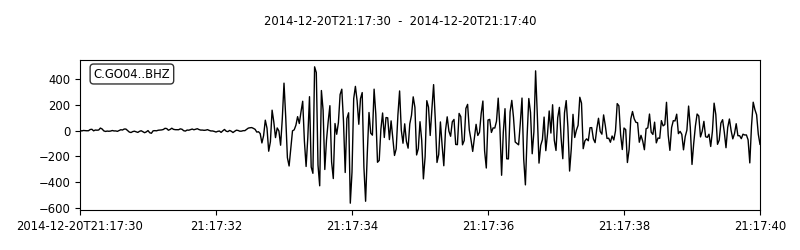

In [32]:
network    = 'C'
station    = 'GO04'
location   = '*'
channel    = 'BHZ'
start_time = obspy.UTCDateTime('2014-12-20T21:17:30Z')
end_time   = start_time + 10
# start_time = obspy.UTCDateTime('2014-12-20T21:17:55Z')
# end_time   = start_time + 10
freq       = 1 # Corner frequency for high-pass filter.

client = obspy.clients.fdsn.Client()
stream = client.get_waveforms(
    network,
    station,
    location,
    channel,
    start_time-5,
    end_time
)
trace = stream[0]
trace.filter('highpass', freq=freq)
trace.trim(starttime=start_time)

plt.close('all')
trace.plot(handle=True);

## Read array geometry file.

In [36]:
import pathlib

/tmp/ipykernel_2019803/2817815147.py:85: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  qmesh = ax2.pcolormesh(
/tmp/ipykernel_2019803/2817815147.py:85: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  qmesh = ax2.pcolormesh(
/tmp/ipykernel_2019803/2817815147.py:85: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  qmesh = ax2.pcolormesh(
/tmp/ipykernel_2019803/2817815147.py:85: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  qmesh = ax2.pcolormesh(
/tmp

CPU times: user 6.64 s, sys: 2.64 s, total: 9.29 s
Wall time: 9.31 s


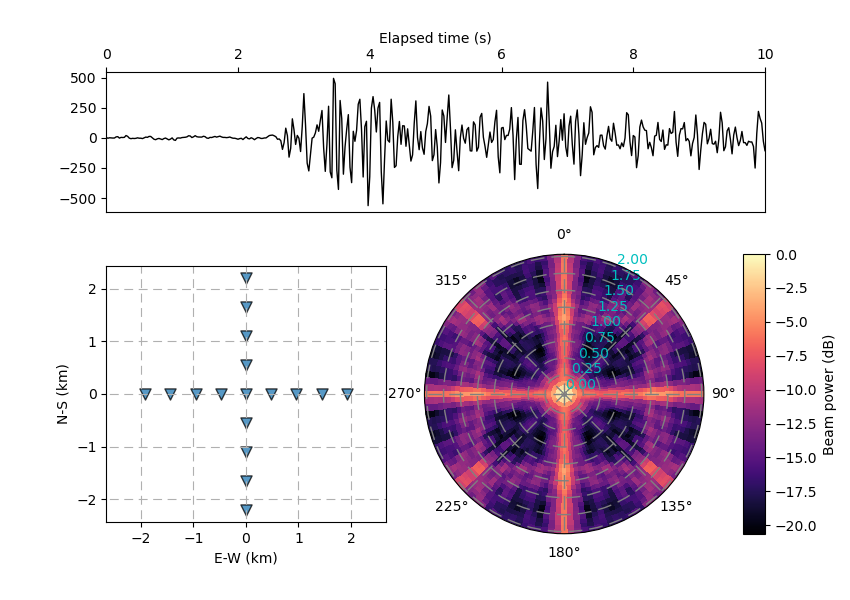

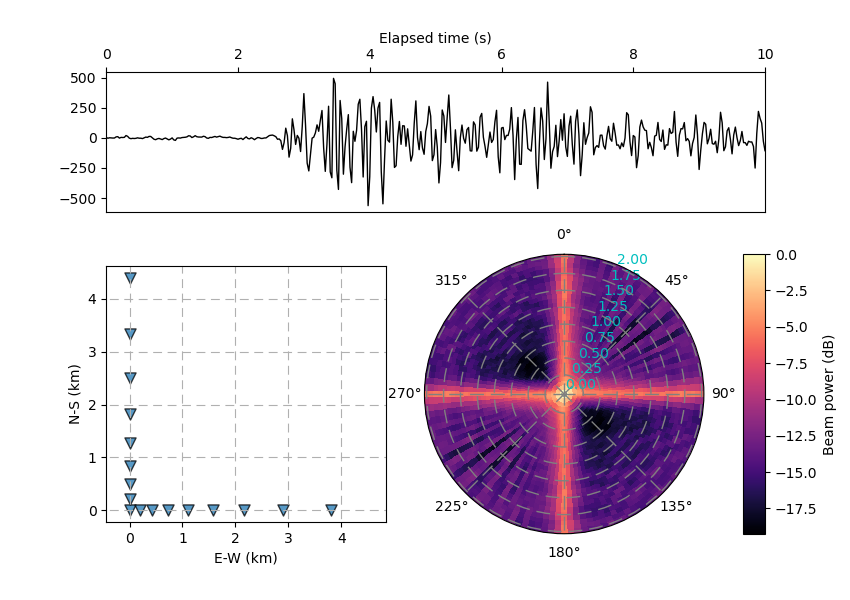

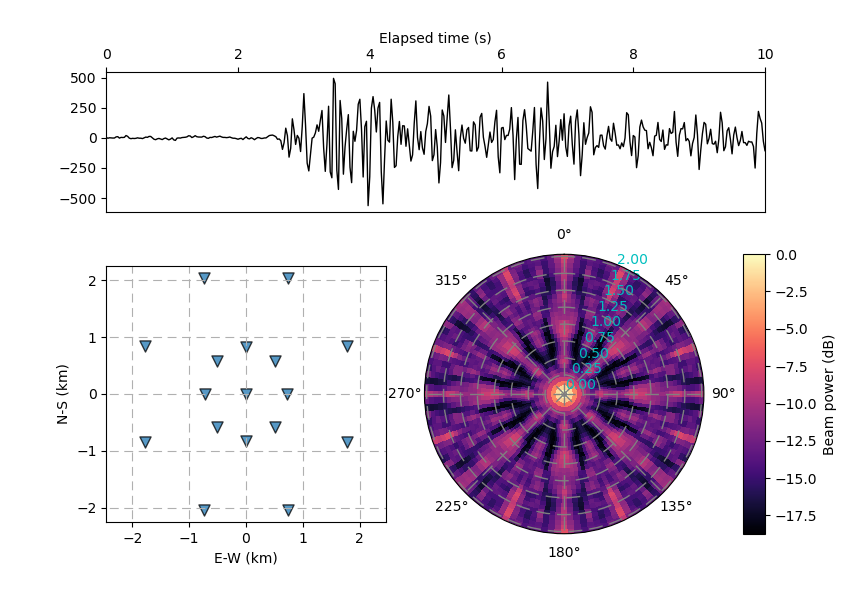

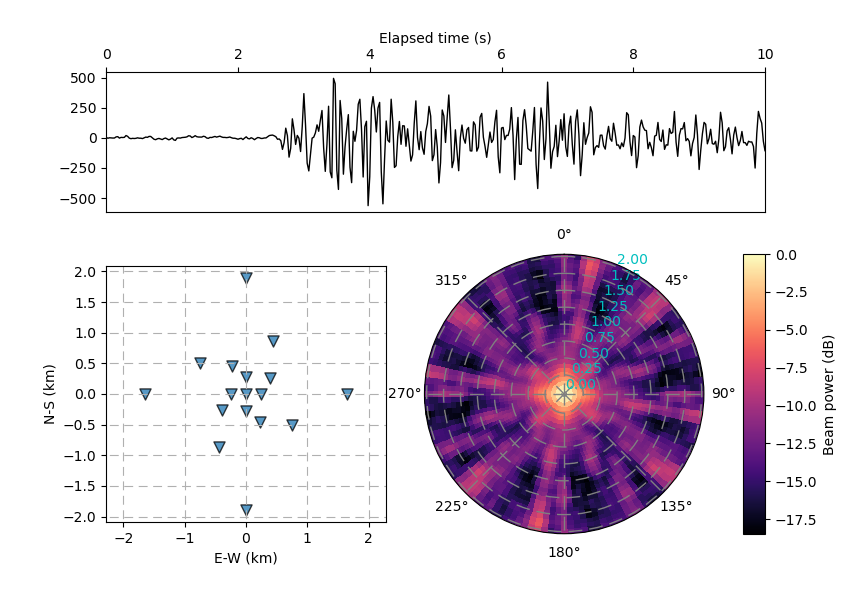

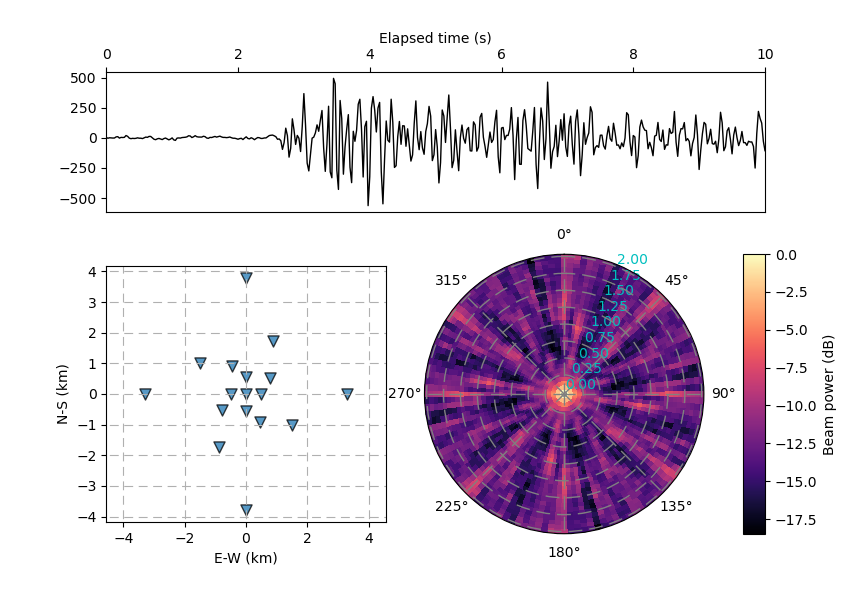

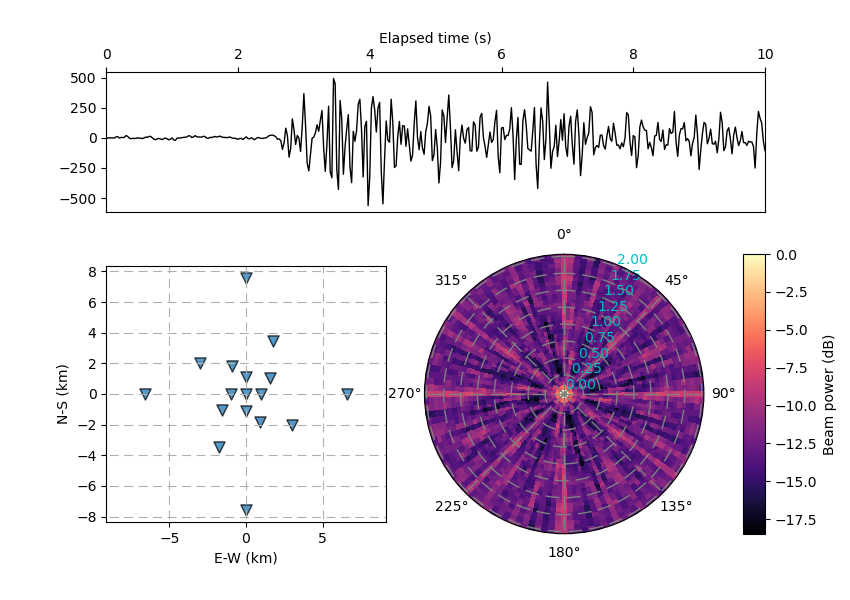

In [39]:
%%time 
# geom = pd.read_csv('../data/geometry/spiral_4x4_0.005.csv')

# geom = pd.read_csv('../data/geometry/lp_cross_8x8_0.002x0.002_1.25x1.25.csv')
# coord_sys = 'cartesian'
# slo_grid = np.mgrid[
#     -2: 2: 1j*16, 
#     -2: 2: 1j*16
# ]

coord_sys = 'polar'
slo_grid = np.mgrid[
    0: 2: 32j,
    0: 360: 129j
]


plt.close('all')

for path in sorted(pathlib.Path('../data/geometry').iterdir()):
    geom = pd.read_csv(path)
    power = compute_response(
        geom, 
        trace,
        slo_grid,
        coord_sys=coord_sys
    )
    plot_response(geom, trace, power, slo_grid, coord_sys)